# Portfolio Hedging Extension

We've simulated one option, now it's time to extend the work to facilitate simulating a portfolio of options. Instead of strike and expiry data we will input a dictionary of data. One thing we need to be careful about is simulating options that don't expire when we finish the simulation.

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# packaged up replication code
from opcoes.black_scholes import compute_prices, compute_greeks
from opcoes.replication import generate_replications, generate_vh_replications
from opcoes.replication import run_delta_hedge_sim, run_delta_hedge_portfolio_sim
from opcoes.simulation import generate_paths

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

In [104]:
# set our simulation settings
sims = 10000

px = 100
rf = 0.00
div = 0.00
sigma = 0.20
years = 1
time_points = 252

greeks=["delta", "gamma", "vega", "volga"]

# set implied vol and use that as vol to compute hedge
# create implied vol series
imp_vols = np.tile([sigma-0.0, sigma+0.0], int(time_points * years) // 2)[:-1]
imp_vols = np.append(sigma, imp_vols)
imp_vols = np.append(imp_vols, sigma)

# imp_vols = None

In [105]:
tenor = 2

positions = [
    {'position': 2,
     'strike': 50,
     'cp': 'C',
     'tenor': tenor
    },
    {'position': -1,
     'strike': 100,
     'cp': 'C',
     'tenor': tenor
    },
    {'position': -1,
     'strike': 100,
     'cp': 'C',
     'tenor': tenor
    },
    {'position': 2,
     'strike': 200,
     'cp': 'C',
     'tenor': tenor
    }
]

In [106]:
pxs, rets, pf_pxs, pf_repls, pf_greeks = run_delta_hedge_portfolio_sim(px, positions, rf, div, sigma, years, sims=sims, time_points=time_points, greeks=greeks, imp_vols=imp_vols, hedge_vols=imp_vols)

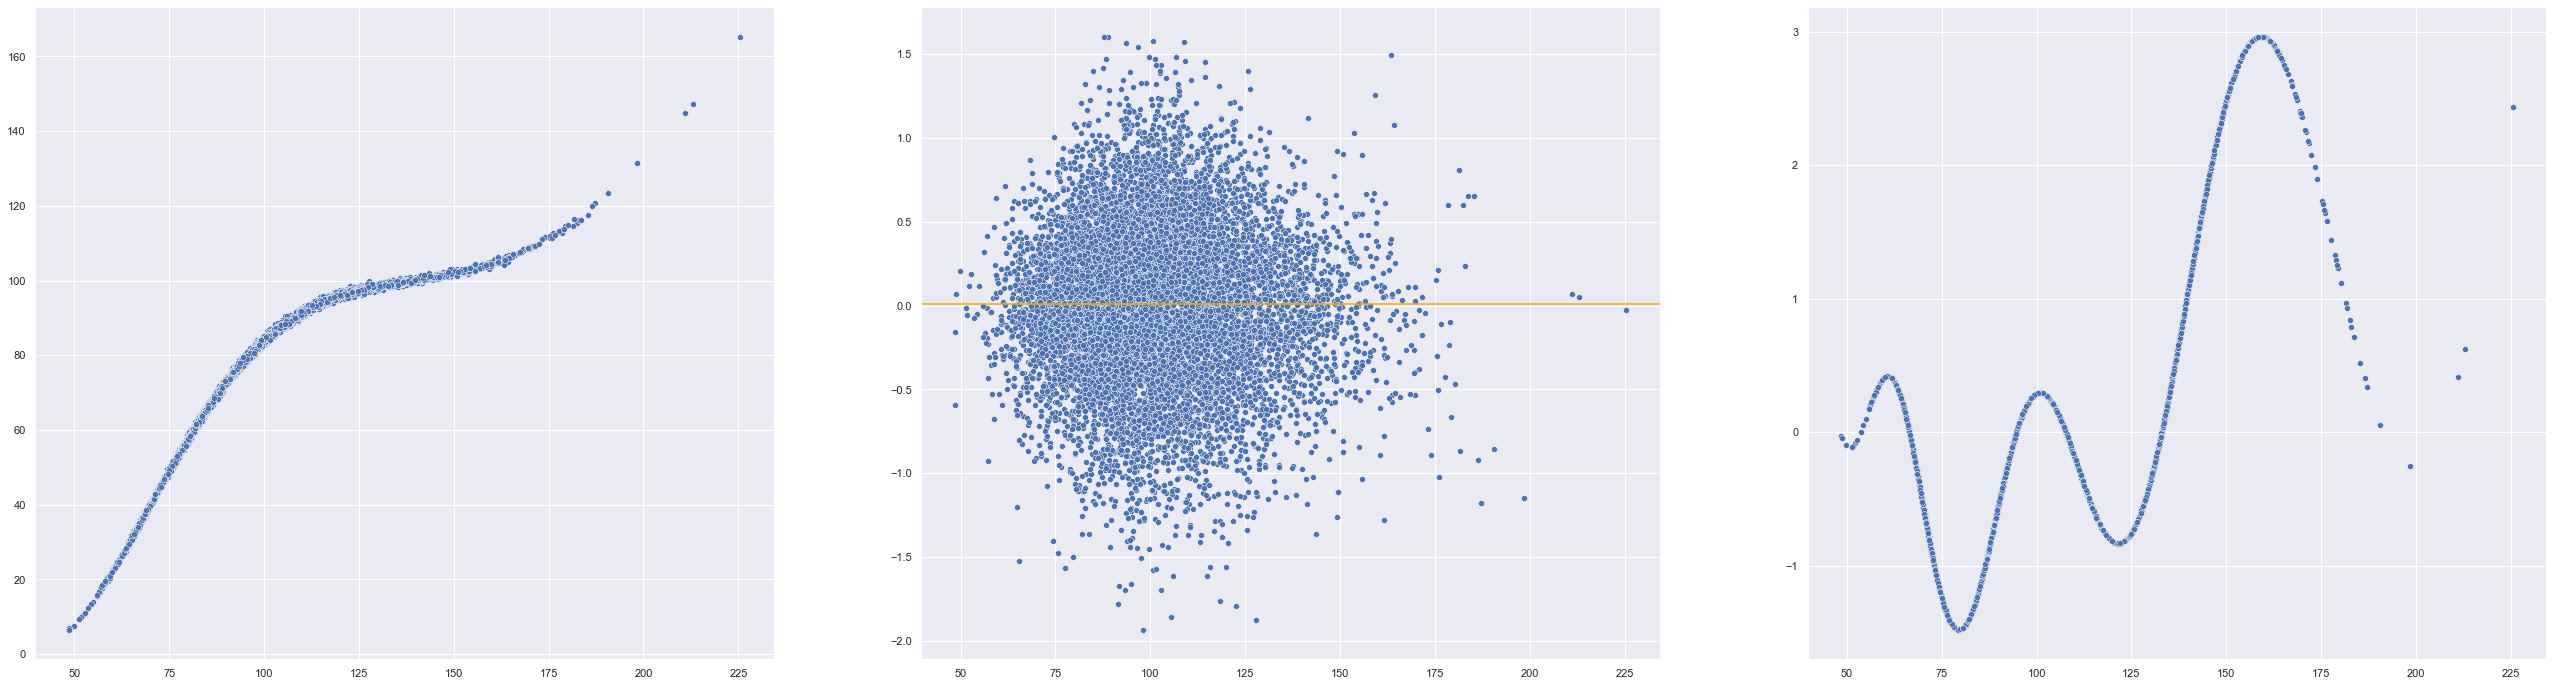

In [107]:
fig, axes = plt.subplots(ncols=3, figsize=(45,12))
axes = axes.reshape(-1)

# scatterplot of replication final payoff
sns.scatterplot(pxs[:, -1], pf_repls[:, -1], ax=axes[0])
# scatterplot of replication hedging error
sns.scatterplot(pxs[:, -1], pf_pxs[:, -1] - pf_repls[:, -1], ax=axes[1])
axes[1].axhline(np.mean(pf_pxs[:, -1] - pf_repls[:, -1]), color='orange')
# scatterplot volga vs finishing spot
sns.scatterplot(pxs[:, -1], pf_greeks['volga'][:, -1], ax=axes[2]);

Now let's compute our vega hedge greeks.

In [108]:
hedge_K = 100
hedge_tenor = tenor

start = hedge_tenor - years
points = int(time_points * years) + 1
times = np.linspace(start, hedge_tenor, points)[::-1]

hedge_greeks = compute_greeks(pxs, hedge_K, rf, div, imp_vols, times, call=True, greeks=greeks, hedge_vols=imp_vols)

pf_vega = pf_greeks['vega']
vh_pxs, vh_repls, vh_vegas = generate_vh_replications(pxs, pf_vega, rf, div, time_points, hedge_greeks)

Text(0.5, 1.0, 'Pnl plot')

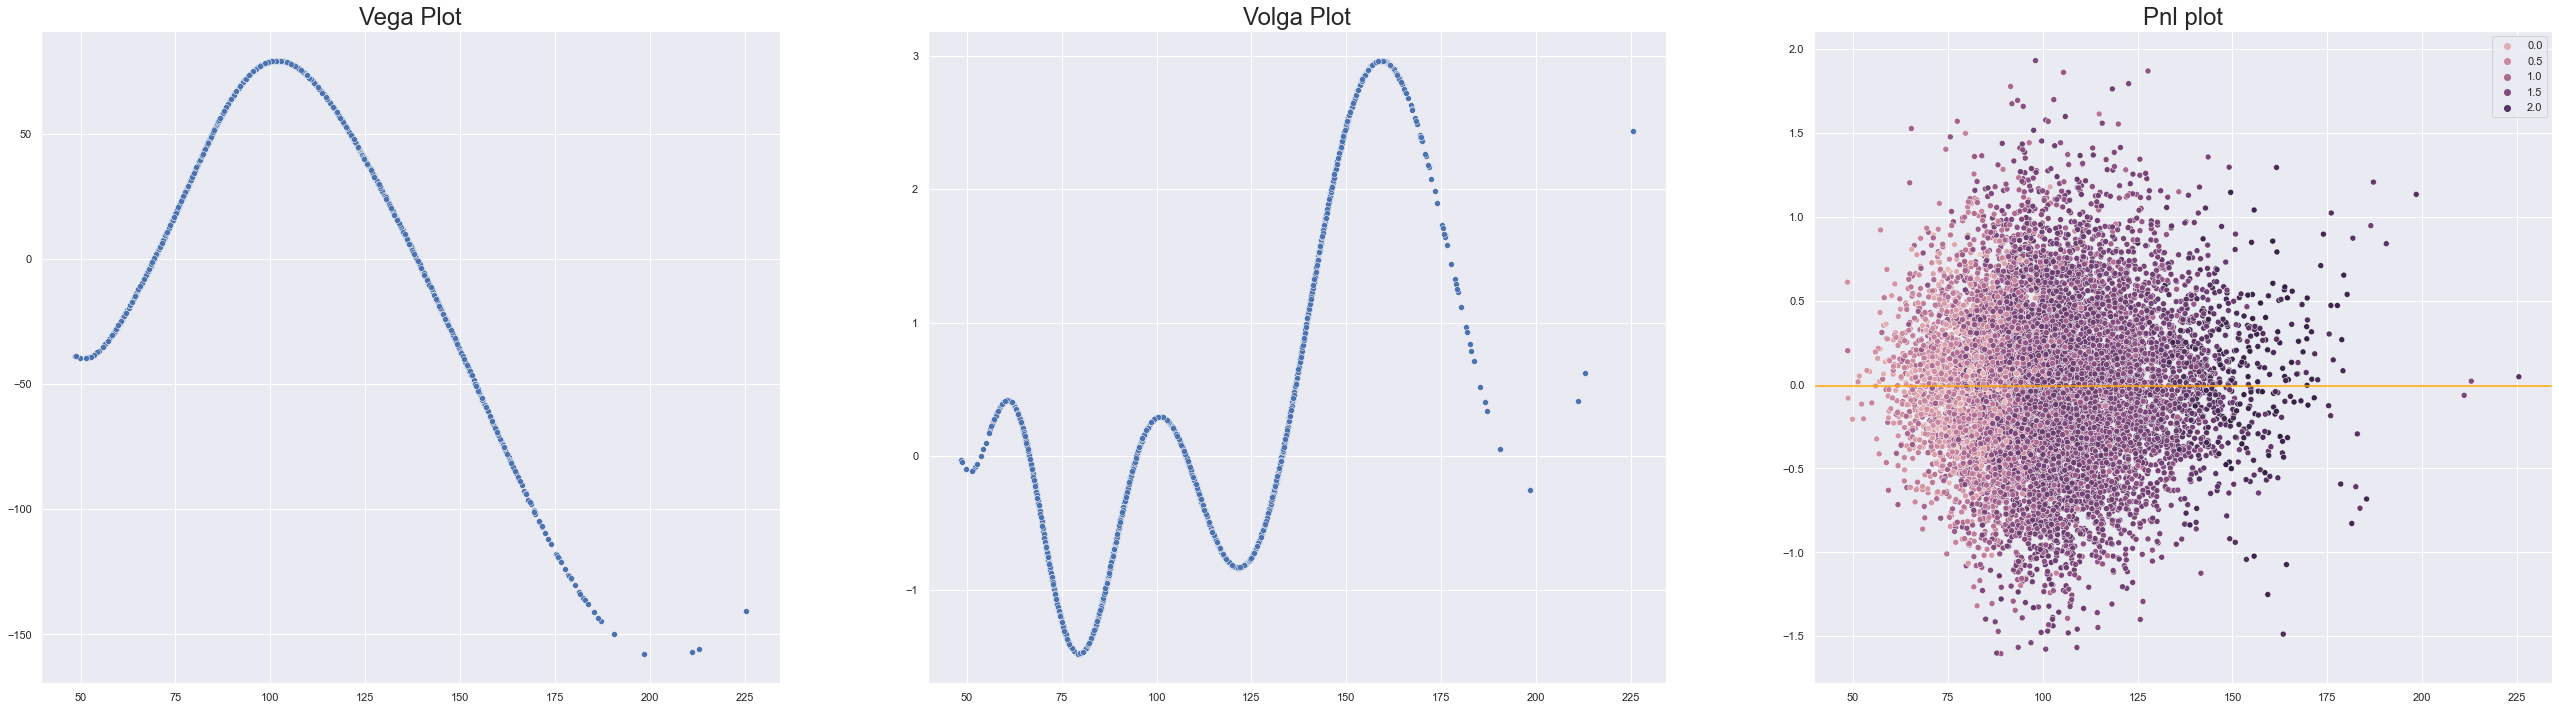

In [110]:
tp = -1

fig, axes = plt.subplots(ncols=3, figsize=(45,12))
axes = axes.reshape(-1)

# scatterplot of replication final payoff
sns.scatterplot(pxs[:, tp], vh_vegas[:, tp], ax=axes[0])
axes[0].set_title('Vega Plot', fontsize=24)
# scatterplot of replication hedging error
sns.scatterplot(pxs[:, tp], pf_greeks['volga'][:, tp], ax=axes[1])
axes[1].set_title('Volga Plot', fontsize=24)

sns.scatterplot(pxs[:, tp], vh_pxs[:, tp] + vh_repls[:, tp], hue=np.mean(pf_greeks['volga'][:,:tp], axis=1), ax=axes[2])
axes[2].axhline(np.mean(vh_pxs[:, tp] + vh_repls[:, tp]), color='orange')
axes[2].set_title('Pnl plot', fontsize=24)
#axes[2].set_ylim(-5, 1 + max(vh_pxs[:, tp] + vh_repls[:, tp]));

In [364]:
# churn out sims using sigma for annual std dev of paths
rets, pxs = generate_paths(px, rf - div, sigma, years, time_points, sims)

# make sure we have implied vols
if imp_vols is None:
    imp_vols = sigma

for p in positions:
    # compute times vector
    tenor = p["tenor"]
    start = tenor - years
    points = int(time_points * years) + 1
    times = np.linspace(start, tenor, points)[::-1]

    # compute option prices and greeks for all times and stock paths
    K = p["strike"]
    call = p["cp"] == "C"
    results = compute_prices_new(
        pxs,
        K,
        rf,
        div,
        imp_vols,
        times,
        call=call,
        greeks=greeks,
        hedge_vols=imp_vols
    )

    p["results"] = results

# combine portfolio prices and deltas
pf_pxs = []
pf_deltas = []
pf_gammas = []
pf_vegas = []
for p in positions:
    pf_pxs.append(p["position"] * p["results"]["pxs"])
    pf_deltas.append(p["position"] * p["results"]["deltas"])
    if "gamma" in greeks:
        pf_gammas.append(p["position"] * p["results"]["gammas"])
    if "vega" in greeks:
        pf_vegas.append(p["position"] * p["results"]["vegas"])

pf_pxs = sum(pf_pxs)
pf_deltas = sum(pf_deltas)
pf_gammas = sum(pf_gammas)
pf_vegas = sum(pf_vegas)

pf_greeks = {
    "pxs": pf_pxs,
    "deltas": pf_deltas,
    "gammas": pf_gammas,
    "vegas": pf_vegas,
}

In [365]:
stock_values, cbs, cfs = generate_replications(pxs, pf_deltas, pf_pxs, rf, div, time_points)

In [366]:
repls = stock_values + cbs

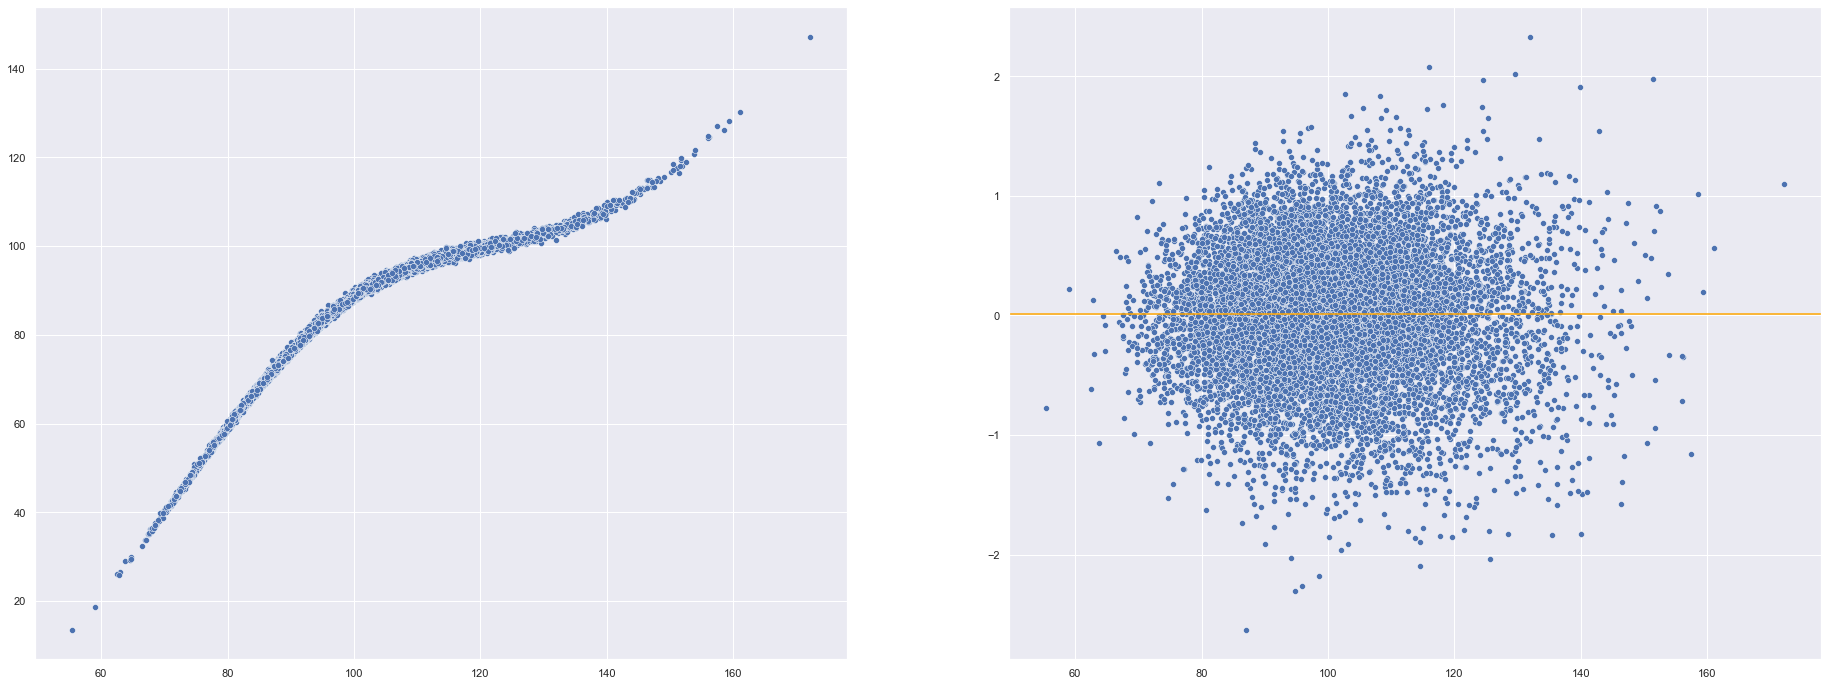

In [367]:
fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

# scatterplot of replication final payoff
sns.scatterplot(pxs[:, -1], repls[:, -1], ax=axes[0])
# scatterplot of replication hedging error
sns.scatterplot(pxs[:, -1], pf_pxs[:, -1] - repls[:, -1], ax=axes[1])
axes[1].axhline(np.mean(pf_pxs[:, -1] - repls[:, -1]), color='orange');

Now we need to compute the data for our vega hedging instrument

In [368]:
start = tenor - years
points = int(time_points * years) + 1
times = np.linspace(start, tenor, points)[::-1]

hedge_greeks = compute_prices_new(pxs, 100, rf, div, imp_vols, times, call=True, greeks=greeks, hedge_vols=imp_vols)

In [369]:
# work out what positions we need to hold in the vega hedge
portfolio_vega = pf_greeks['vegas']
hedge_vega = hedge_greeks['vegas']
options_to_hold = - portfolio_vega / hedge_vega

# now let's diff that to see how much we trade at each point
ops_to_trade = np.diff(options_to_hold)
# we can use this to work out the premium cashflow we capture
hedge_pxs = hedge_greeks['pxs']
# we trade the quantity, so pay/receive the negative of the quantity
rehedge_prems = - ops_to_trade * hedge_pxs[:, 1:]

# compute the hedge delta at all points
# this will be the hedge instrument delta mult by how much we hold
hedge_deltas = options_to_hold * hedge_greeks['deltas']
hedge_delta_chgs = np.diff(hedge_deltas, axis=1)

# compute value of vega hedge's delta hedge at each point
hedge_stock_values = - hedge_deltas * pxs

# compute the cash generated by re-hedging the delta
hedge_delta_rehedge_cfs = hedge_delta_chgs * pxs[:, 1:]

# compute div cash flows
# we hold the opposite of our hedge deltas
hedge_div_cfs = - hedge_deltas[:, :-1] * pxs[:, :-1] * div / time_points

# now let's initialise our cash vectors
init_prems = - options_to_hold[:, 0] * hedge_pxs[:, 0]
init_stock_costs = options_to_hold[:, 0] * hedge_greeks['deltas'][:, 0] * pxs[:, 0]
init_cbs = init_prems + init_stock_costs

hedge_cbs = [init_cbs]
hedge_cfs = [np.zeros(len(pxs[:, 0]))]

# now we work through each time step
for h_drh, h_dcf, h_rhp in zip(hedge_delta_rehedge_cfs.T, hedge_div_cfs.T, rehedge_prems.T):

    # get previous cash balance
    prev_cash = hedge_cbs[-1]
    # future value it
    new_cash = prev_cash * (1 + rf / time_points)
    # add on new cash flows which are:
    # - from div payments
    # - from re-hedging more options
    # - from delta-hedging the resulting structure
    cf = h_drh + h_dcf + h_rhp
    cb = new_cash + cf
    hedge_cfs.append(cf)
    hedge_cbs.append(cb)

hedge_cfs = np.array(hedge_cfs).T
hedge_cbs = np.array(hedge_cbs).T

In [370]:
hedge_repls = hedge_stock_values + hedge_cbs
hedge_pf_pxs = options_to_hold * hedge_greeks['pxs']

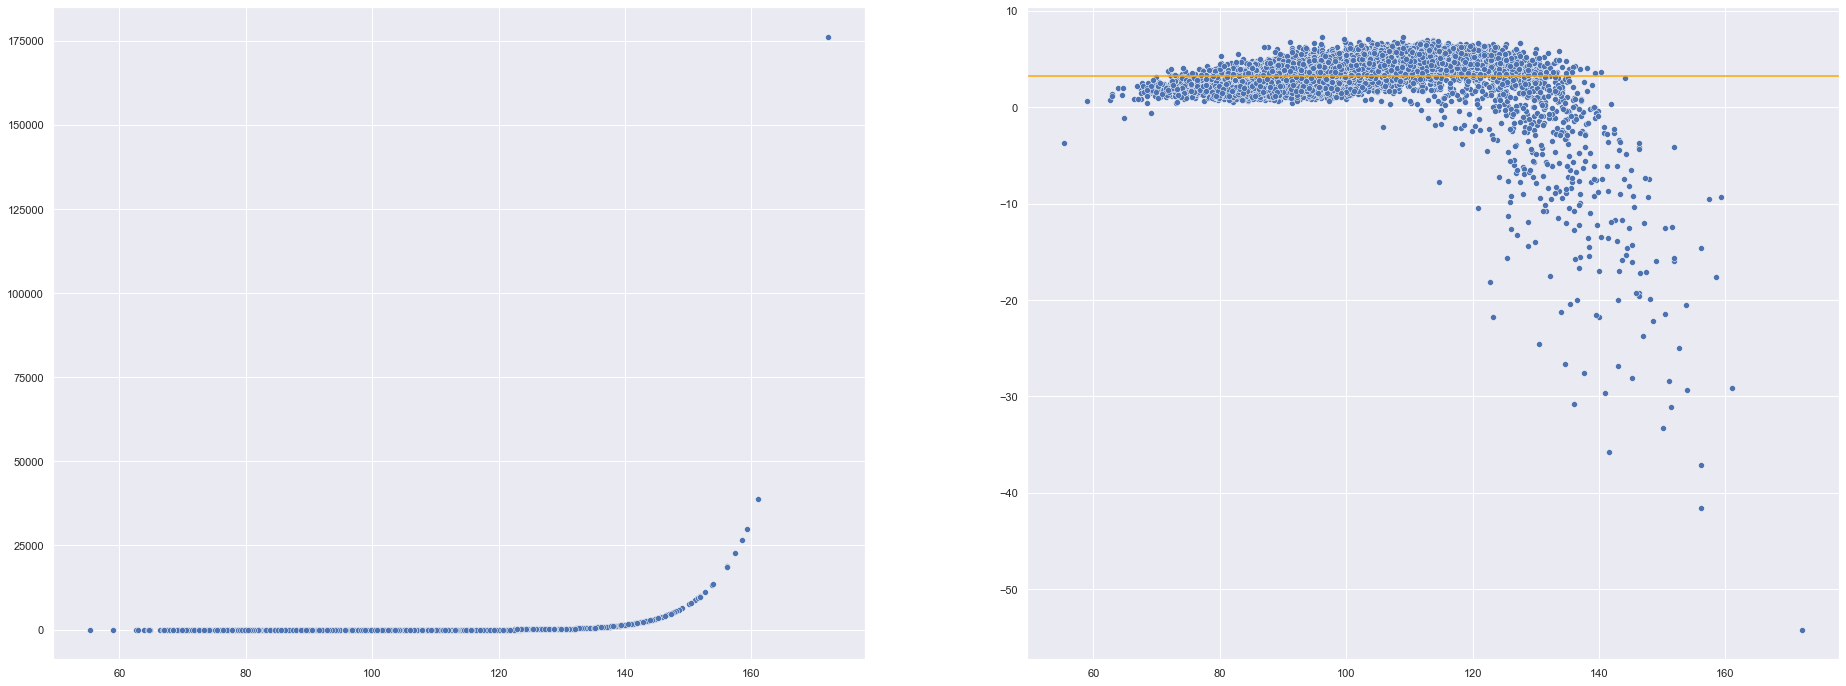

In [371]:
fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

# scatterplot of replication final payoff
sns.scatterplot(pxs[:, -1], hedge_repls[:, -1], ax=axes[0])
# scatterplot of replication hedging error
sns.scatterplot(pxs[:, -1], hedge_pf_pxs[:, -1] + hedge_repls[:, -1], ax=axes[1])
axes[1].axhline(np.mean(hedge_pf_pxs[:, -1] + hedge_repls[:, -1]), color='orange');

Let's hue the pnl plot by the average volga over the life time of the option